In [36]:
import retrieve as rt
import bt

symbols = list(rt.Basket().get_portfolio().keys())

symbols.extend(rt.GetTicker().recommend_tickers())

df = bt.get(symbols,start="2020-01-01")

404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ECC%20%20%20%20%20%20%20%20%20%20%20?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ECC+++++++++++&crumb=hkqkt%2FzpnuA
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/SAND%20%20%20%20%20%20%20%20%20%20?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=SAND++++++++++&crumb=hkqkt%2FzpnuA


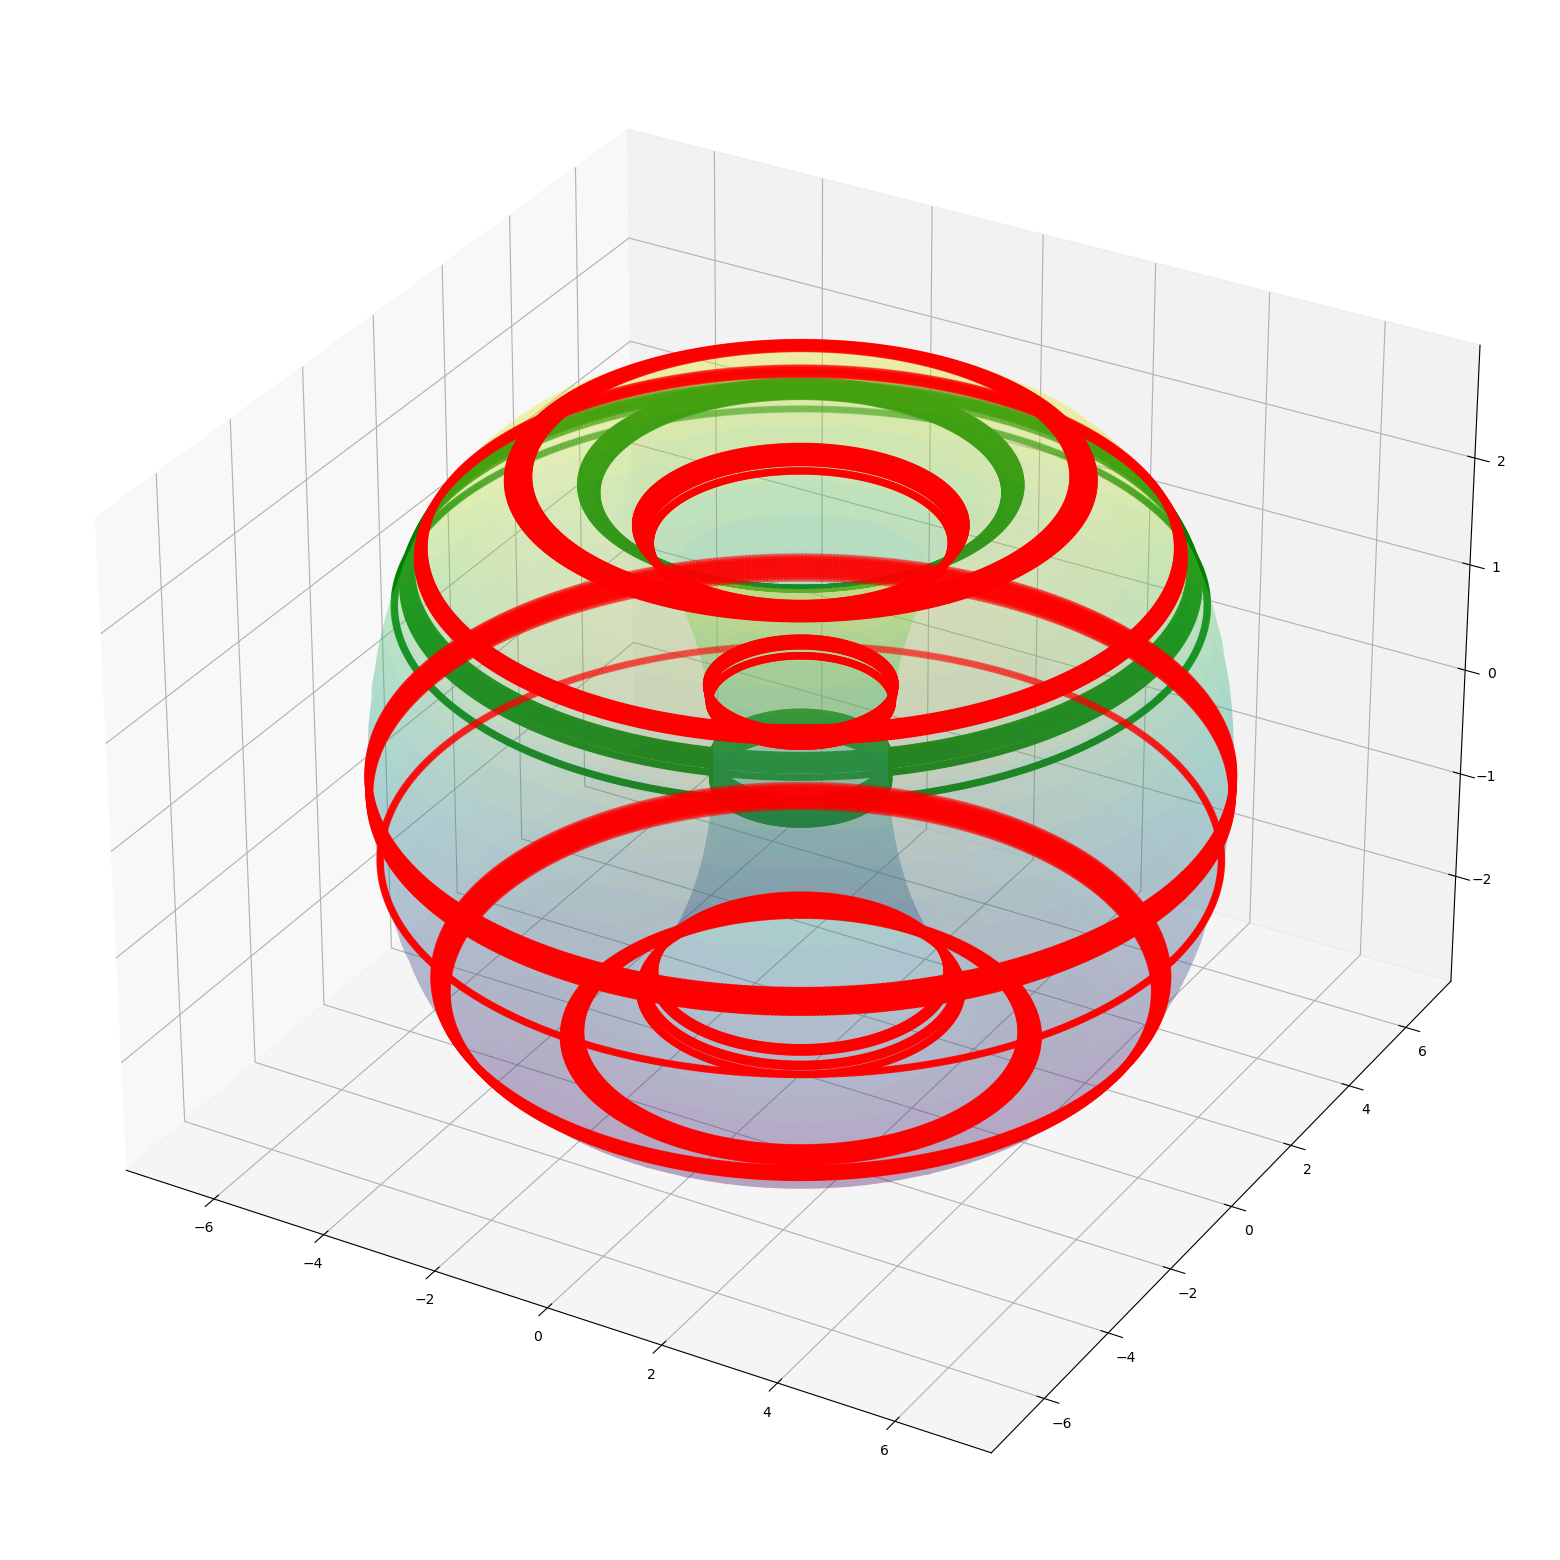

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_torus(ticker,big,rolling_mean,rolling_std,buy_signal,sell_signal,size):
    # Define parametric equations for a torus
    def torus_parametric(u, v, R, r):
        x = (R + r * np.cos(v)) * np.cos(u)
        y = (R + r * np.cos(v)) * np.sin(u)
        z = r * np.sin(v)
        return x, y, z

    # Parameters for the torus
    R = (rolling_mean[ticker] + (2 * rolling_std[ticker])).mean()  # Major radius
    r = rolling_mean[ticker].mean()  # Minor radius

    # Generate torus coordinates
    u = np.linspace(0,big,size)
    v = np.linspace(0,big,size)
    U, V = np.meshgrid(u, v)
    X, Y, Z = torus_parametric(U, V, R, r)

    # Plot the torus
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, alpha=0.2, cmap='viridis')

    # Plot the price data
    ax.scatter(X[buy_signal[ticker]], Y[buy_signal[ticker]], Z[buy_signal[ticker]], color='g', label='Buy Signal')
    ax.scatter(X[sell_signal[ticker]], Y[sell_signal[ticker]], Z[sell_signal[ticker]], color='r', label='Sell Signal')
    ax.tick_params(labelsize=10)
    
    plt.show()

big = 2*np.pi

df_filter = df - df.iloc[0]

norm_price = (df_filter - df_filter.min()) / (df_filter.max() - df_filter.min()) * big

rolling_mean = norm_price.rolling(window=50).mean()
rolling_std = norm_price.rolling(window=50).std()

buy_signal = norm_price < rolling_mean - (2 * rolling_std)
sell_signal = norm_price > rolling_mean + (2 * rolling_std)

plot_torus("cort",big,rolling_mean,rolling_std,buy_signal,sell_signal,len(df))

In [38]:
def action_tickers(ticker,buy_indicator,sell_indicator):
    tick_buy = pd.DataFrame(buy_indicator[ticker])
    tick_buy["BuySignal"] = "Buy"
    tick_buy = tick_buy.rename(columns={ticker:"BuyAction"})

    tick_sell = pd.DataFrame(sell_indicator[ticker])
    tick_sell["SellSignal"] = "Sell"
    tick_sell = tick_sell.rename(columns={ticker:"SellAction"})

    actions = pd.concat([tick_buy,tick_sell],axis=1)
                     
    actions.loc[(actions["BuyAction"] == False) & (actions["SellAction"] == False), ["BuySignal","SellSignal"]] = "Hold"

    buy = actions.loc[(actions["BuySignal"] == "Buy") & (actions["BuyAction"] == True), "BuySignal"]
    sell = actions.loc[(actions["SellSignal"] == "Sell") & (actions["SellAction"] == True), "SellSignal"]
    hold = actions.loc[(actions["BuySignal"] == "Hold") & (actions["SellSignal"] == "Hold"), "BuySignal"]

    actions = pd.concat([buy,sell,hold],axis=0).reset_index()

    actions.columns = ["Date", ticker + "Signal"]

    actions = actions.sort_values(by="Date",ascending=True).reset_index(drop=True)

    actions = actions.drop(["Date"],axis=1)

    return actions

ticker_action = pd.DataFrame(buy_signal.index)

for tick in symbols:
    ticker_action[tick.lower() + "Signal"] = action_tickers(tick.lower(),buy_signal,sell_signal)

date = ticker_action.pop("Date")
ticker_action = ticker_action.set_index(date)

ticker_action.iloc[51:]

,cdlxSignal,cvxSignal,pyplSignal,modSignal,calmSignal,indaSignal,anfSignal,ymmSignal,cortSignal,dloSignal,gntxSignal,incySignal
Date,,,,,,,,,,,,
2021-09-03,Hold,Hold,Hold,Hold,Hold,Sell,Hold,Hold,Hold,Hold,Hold,Hold
2021-09-07,Hold,Hold,Hold,Hold,Sell,Sell,Hold,Hold,Hold,Hold,Hold,Hold
2021-09-08,Hold,Hold,Hold,Hold,Sell,Sell,Hold,Hold,Hold,Hold,Hold,Hold
2021-09-09,Hold,Hold,Hold,Hold,Hold,Sell,Hold,Hold,Hold,Hold,Hold,Hold
2021-09-10,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Buy
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-20,Hold,Hold,Hold,Hold,Hold,Hold,Sell,Sell,Sell,Buy,Hold,Hold
2024-05-21,Hold,Hold,Hold,Hold,Hold,Hold,Sell,Hold,Sell,Buy,Hold,Hold
2024-05-22,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Sell,Buy,Hold,Hold


<Axes: title={'center': 'Equity Progression'}>

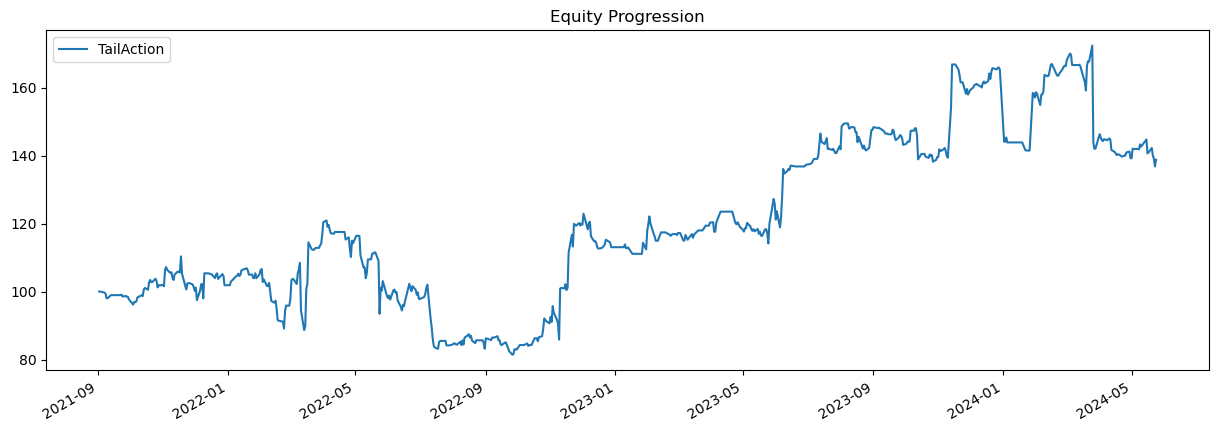

In [39]:
strat1 = bt.Strategy('buyTailAction', [bt.algos.SelectWhere(buy_signal),
                                       bt.algos.WeighEqually(),
                                       bt.algos.Rebalance()])

# now we create the Backtest
t1 = bt.Backtest(strat1, df.iloc[51:,:],integer_positions=False, progress_bar=True)

strat2 = bt.Strategy('sellTailAction', [bt.algos.SelectWhere(sell_signal),
                                       bt.algos.WeighEqually(),
                                       bt.algos.Rebalance()])

# now we create the Backtest
t2 = bt.Backtest(strat2, df.iloc[51:,:],integer_positions=False, progress_bar=True)

tests = [t1,t2]

combined_strat = bt.Strategy('TailAction', [bt.algos.SelectAll(),
                                            bt.algos.WeighEqually(),
                                            bt.algos.Rebalance()],
                                            children = [x.strategy for x in tests])

combined_test = bt.Backtest(
    combined_strat,
    df.iloc[51:,:],
    integer_positions = False,
    progress_bar = False
)

res = bt.run(combined_test)

res.plot()

In [40]:
res.stats

,TailAction
start,2021-09-02 00:00:00
end,2024-05-24 00:00:00
rf,0.0
total_return,0.387697
cagr,0.127806
max_drawdown,-0.326449
calmar,0.391503
mtd,-0.003583
three_month,-0.154466
six_month,-0.140899


import json
import requests
import os
import yfinance as yf

criteria = json.loads(open(os.getcwd() + "\\criteria.json","r").read())

tickers = list(criteria["Portfolio Weights"].keys())

for stock_ex in criteria["Exchanges"]:
    github_branch = "https://raw.githubusercontent.com/rreichel3/US-Stock-Symbols/main"
    exchange =  "/" + stock_ex + "/" + stock_ex + "_full_tickers.json" 

    url = github_branch + exchange # combining the repository dataset with the specific exchange

    resp = requests.get(url)
    data = json.loads(resp.text)

    for i in range(len(data)):
        ticker = data[i]

        immediate_criteria = list(criteria["Immediate Criteria"].keys()) # ["lastsale", "volume", "marketCap"]
        
        # important to note that since the list of tickers is massive, need to find any method to narrow scope

        # Step 1: Check to see if anything is blank from the full json file or ticker already in portfolio
        if ticker["symbol"] in tickers or any(ticker[checker] == "" for checker in immediate_criteria): 
            continue

        # numeric comparison
        lastsale = float(ticker[immediate_criteria[0]][1:])
        volume = float(ticker[immediate_criteria[1]])
        marketCap = float(ticker[immediate_criteria[2]])

        # Step 2: eliminate low cost stocks, less volume, and bound the marketcap due to portfolio size
        check_1 = lastsale > criteria["Immediate Criteria"][immediate_criteria[0]] \
            and volume > criteria["Immediate Criteria"][immediate_criteria[1]]
            
        check_2 = marketCap <= criteria["Immediate Criteria"][immediate_criteria[2]]

        if check_1 and check_2:
            greater = criteria["Portfolio Criteria"]["Greater"]
            less_than = criteria["Portfolio Criteria"]["Less Than"]

            symbol = ticker["symbol"]

            # list of metrics for criteria
            metrics = list(greater.keys())
            metrics.extend(list(less_than.keys()))

            values = dict(filter(lambda item: item[0] in metrics, yf.Ticker(symbol).info.items()))
            
            try:
                # Step 3: select tickers whick satisfy all of these conditions
                check_3 = all(values[metric] > x for metric,x in greater.items()) 
                check_4 = all(values[metric] < x for metric,x in less_than.items())
                if check_3 and check_4:
                    tickers.append(symbol)

            except KeyError:
                continue

print(tickers)